## Do we see a wedge in our visibilities?

In [1]:
%load_ext autoreload
import sys
sys.path.append("..")
import imcurio as imc
from numpy.fft import fft,fftfreq,rfft,rfftfreq
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [2]:
%autoreload
B = imc.SimBox("../sims/HImesh_0512_z100.fits")
Bf = imc.SimBox("../sims/Sky_0512_z100_060.0-30.0.fits", conversions_from = B)
T=imc.TelSim(N=128)
vis = T.get_visibilities(B,vopts={'interpolation':'lasz','a':3.0})
visf = T.get_visibilities(Bf,vopts={'interpolation':'lasz','a':3.0})

Box size: 32.81-20.88 deg from z=0.72-1.33
Beam sigma: 1.89-2.56 deg from z=0.72-1.33
Beam sigma at the edge: 8.67 - 4.07 
Beam sigma: 1.89-2.56 deg from z=0.72-1.33
Beam sigma at the edge: 8.67 - 4.07 


In [3]:
def getPkVis(T,vis,Nkpar=256,Nkperp=15):
    Pk = np.zeros((Nkperp,Nkpar))
    Pkw = np.zeros_like(Pk)
    uv = np.sqrt(T.u_m**2+T.v_m**2)
    duv = ((uv-uv.min())/(1.001*uv.max()-uv.min())*Nkperp).astype(int)
    for cvis,ii in zip((vis).T,duv):
        ## lets pad with zeros
        cvis = np.hstack((cvis,np.zeros_like(cvis)))
        Nx=len(cvis)
        fcvis=fft(cvis)
        cPk = abs(fcvis[1:Nx//2+1]**2)+abs(fcvis[-1:-(Nx//2+1):-1]**2)
        cPkbin = cPk.reshape((-1,Nkpar)).mean(axis=0)
        Pk[ii,:] += cPkbin
        Pkw[ii,:] += 1
    Pk/=Pkw
    return Pk

In [4]:
## radial frequency binning 
dfpar=2*np.pi/(2*B.Lbox) ## we pad
## perpendicular
uv = np.sqrt(T.u_m**2+T.v_m**2)
kperlow = uv.min()*B.mtoIMpch
kperhigh = uv.max()*B.mtoIMpch

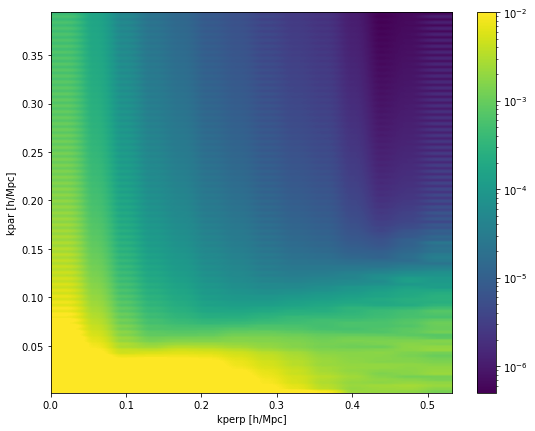

In [5]:
Pk = getPkVis(T,visf)
plt.figure(figsize=(9,7))
plt.imshow(Pk[1:,:128].T,origin='lower',norm=LogNorm(),aspect='auto',vmax=1e-2, 
           extent=(kperlow,kperhigh,0.5*dfpar,128.5*dfpar))
plt.xlabel('kperp [h/Mpc]')
plt.ylabel('kpar [h/Mpc]')
plt.colorbar()


Beam sigma: 1.89-2.56 deg from z=0.72-1.33
Beam sigma at the edge: 8.67 - 4.07 


[]

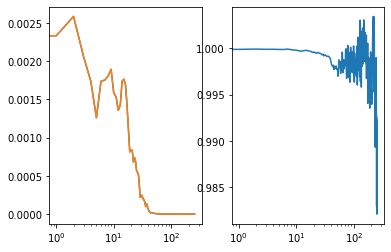

In [6]:
# does padding matter?
visfP = T.get_visibilities(Bf,pad=4,vopts={'interpolation':'lasz','a':3.0})
PkP = getPkVis(T,visfP)
plt.subplot(1,2,1); plt.plot(Pk[13,:]); plt.plot(PkP[13,:]); plt.semilogx()
plt.subplot(1,2,2); plt.plot(PkP[13,:]/Pk[13,:]); plt.semilogx()

Beam sigma: 1.89-2.56 deg from z=0.72-1.33
Beam sigma at the edge: 8.67 - 4.07 


[]

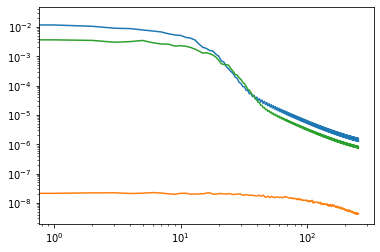

In [7]:
PkSig = getPkVis(T,vis)
Pk = getPkVis(T,visf)
plt.plot(Pk[8,:]); 
plt.plot(PkSig[8,:]);

#Pk2 = getPkVis(T,T.get_visibilities(Bf,vopts={'interpolation':'lin'}))
Pk2 = getPkVis(T,T.get_visibilities(Bf,vopts={'a':2.0}))

plt.plot(Pk2[10,:]); 


plt.loglog()

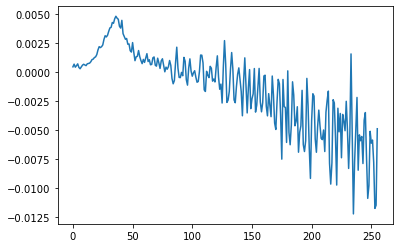

In [8]:
plt.plot(Pk[10,:]/Pk2[10,:]-1); 
#plt.loglog()

[]

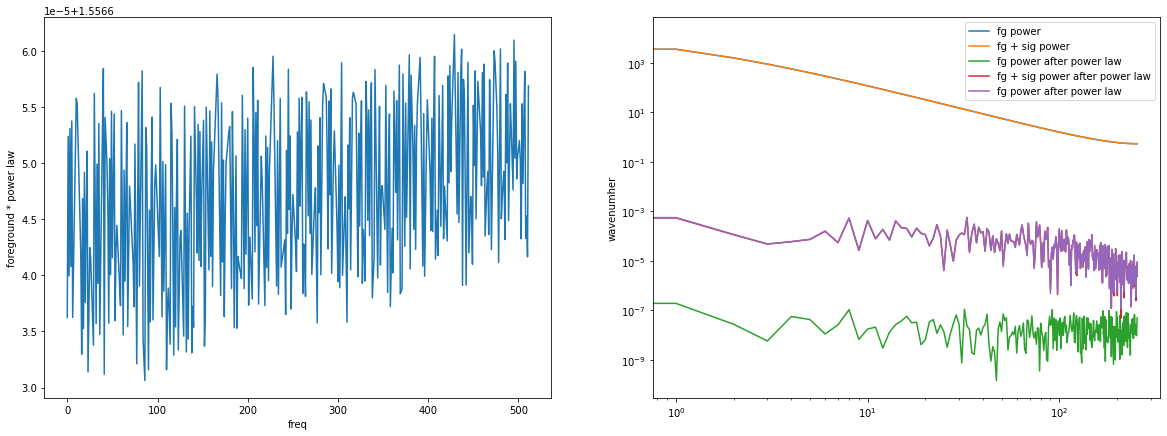

In [9]:

plt.figure(figsize=(20,7))
fg=Bf.box[50,50,:]; sg=B.box[20,20,:]
freqw=(Bf.freq/711)**2.96607
plt.subplot(1,2,1)
plt.plot(fg*freqw)
plt.ylabel("foreground * power law")
plt.xlabel("freq")
#plt.semilogy()
plt.subplot(1,2,2)
plt.plot(abs(rfft(fg)**2)[1:],label='fg power')
plt.plot(abs(rfft(fg+sg)**2)[1:],label='fg + sig power')
plt.plot(abs(rfft(fg*freqw)**2)[1:], label = 'fg power after power law')
plt.plot(abs(rfft((fg+sg)*freqw)**2)[1:], label='fg + sig power after power law')
plt.plot(abs(rfft((sg)*freqw)**2)[1:], label='fg power after power law')
plt.legend()
plt.ylabel("Pk1D")
plt.ylabel("wavenumher")
plt.loglog()

In [10]:
import scipy.linalg as la

def fit3poly (x):
    N = len(x)
    H = N // 3
    G = 2*N // 3
    F = N-1
    mat = np.array([[ 0, 0, 0, 1], [H**3,H**2, H, 1],[G**3,G**2, G, 1],[F**3,F**2, F, 1]])
    a,b,c,d=np.dot(la.inv(mat),np.array([x[0],x[H],x[G],x[F]]))
    xv = np.arange(len(x))
    return a*xv**3+b*xv**2+c*xv+d

    

In [11]:
freq = fit3poly(Bf.freq)

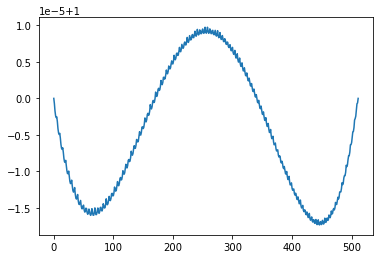

In [12]:
plt.plot(Bf.freq/freq)